## 1. Get data from two sources:  
• Collects data of your choosing from an API (i.e. Wikipedia, NYT, or other)  
• Collects data from a web page using scraping with BeautifulSoup (it is also possible to
use Selenium)  

### my choice:
DATA from API:  articles related to "data scientist" in NYT api   
Web scraping data: U.S. News'  Best Jobs

In [1]:
## imports
!pip install requests
import requests as rq
from urllib.parse import urlencode
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
import copy
from bs4 import BeautifulSoup as bs
import re
from time import sleep
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

###  get data from API (NYT)

In [2]:
## access NYT API , set the key word to be "data scientist"
api_key = 'ITqGKYBATC61fM67Lr6RvuhQKCRkEwgt'
query = "data scientist"

In [3]:
base_url="https://api.nytimes.com/svc/search/v2/articlesearch.json?"

params={"q":query,"api-key":api_key,"fq": 'body:"data scientist"',"begin_date":"20230101"}
response=rq.get(base_url+urlencode(params))
response

<Response [200]>

In [4]:
## turn the response data into json 
response=response.json()

Got data from API

---

### get data using web scraping

Web scraping data: U.S. News' Best Jobs in different fields  https://money.usnews.com/careers/best-jobs/rankings

In [5]:
## test if we can access the website by web scraping
HEADERS = {"User-agent": "Mozilla/5.0 (iPad; CPU OS 12_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148"}
page_raw = rq.get("https://money.usnews.com/careers/best-jobs/rankings",headers=HEADERS)
page_raw

<Response [200]>

In [6]:
## turn the entire page into beautifulsoup
page_soup = bs(page_raw.text)
 
## now we need to access many job ranking pages from this website
## ranking information are put in two different places in the website,so i decide to deal with each of them then put them into one list.
rankings_soup = page_soup.find_all(
    "li", class_="rankings-index__ListItemStyled-n9ivl8-1 Cell-sc-1abjmm4-0-rankings-index__ListItemStyled hUGzM ghhnDt")
rankings_soup2=page_soup.find_all(
    "li", class_="rankings-index__ListItemStyled-n9ivl8-1 Cell-sc-1abjmm4-0-rankings-index__ListItemStyled hUGzM keXiNB")
ranking_page_soup=rankings_soup+rankings_soup2
len(ranking_page_soup)

17

now, inside this list(ranking_soup), there are 17 rankings. i'll start to explore each of them and pick out information we need for a dataframe

In [7]:
ranking_page_soup[0]

<li class="rankings-index__ListItemStyled-n9ivl8-1 Cell-sc-1abjmm4-0-rankings-index__ListItemStyled hUGzM ghhnDt"><div class="CardRanking__CardContainer-sc-7t385z-1 wwtQd rankings-index__CardRankingStyled-n9ivl8-4 gCZXDH t-font-fam border"><div class="CardRanking__CardBgImage-sc-7t385z-0 iNqbGV"><a class="Anchor-byh49a-0 eMEqFO" href="https://money.usnews.com/careers/best-jobs/rankings/the-100-best-jobs"></a></div><div class="CardRanking__ContentBox-sc-7t385z-2 fvZkqh p2"><h3 class="Heading-sc-1w5xk2o-0 eKEGBN" style="position:relative"><a class="Anchor-byh49a-0 dKVMQA" href="https://money.usnews.com/careers/best-jobs/rankings/the-100-best-jobs">The 100 Best Jobs</a></h3><ul class="RankList__List-sc-2xewen-0 hIzLil rank-list" font-size="4" spacing="0"><li class="RankList__ListItem-sc-2xewen-1 dofuo rank-list-item"><a class="RankList__RankLink-sc-2xewen-3 iJNAOy has-badge" href="https://money.usnews.com/careers/best-jobs/software-developer"><div class="RankList__Rank-sc-2xewen-2 dXcKoP 

In [8]:
## first, before we enter those 17 rankings, i'll store the names of ranking lists as a new list.
## since all the jobs in the rankings are under the same catagory as the name of the ranking, let's name the list to be job catagory:
job_cata=[]
for i in ranking_page_soup:
    title=i.find_all("h3",class_="Heading-sc-1w5xk2o-0 eKEGBN")
    title2=i.find_all("h3",class_="Heading-sc-1w5xk2o-0 Card__CardHeading-lfbmbq-1 jUptUn gqyhvg")
    job_cata=job_cata+title+title2
    

In [9]:
## let's see what kind of rankings we got:
for i in job_cata:
    print(i.text)

The 100 Best Jobs
Best Health Care Jobs
Best-Paying Jobs
Best Business Jobs
Best Technology Jobs
Best STEM Jobs
Best Health Care Support Jobs
Best Jobs Without a College Degree
Highest Paying Jobs Without a Degree
Best Science Jobs
Best Construction Jobs
Best Sales and Marketing Jobs
Best Creative and Media Jobs
Best Education Jobs
Best Maintenance and Repair Jobs
Best Social Services Jobs
Best Engineering Jobs


In [10]:
## some of the rankings don't consist jobs in the same field,which don't fulfull our need.(like"100 best jobs") 
## so we kick them off

list_delete=["The 100 Best Jobs","Best-Paying Jobs","Highest Paying Jobs Without a Degree","Best Jobs Without a College Degree"]
for i in range(5):
    for i in job_cata:
        if i.text in list_delete:
            job_cata.remove(job_cata[job_cata.index(i)])
            
## now we got the rankings we want            
for i in job_cata:
    print(i.text)

print(len(job_cata))

Best Health Care Jobs
Best Business Jobs
Best Technology Jobs
Best STEM Jobs
Best Health Care Support Jobs
Best Science Jobs
Best Construction Jobs
Best Sales and Marketing Jobs
Best Creative and Media Jobs
Best Education Jobs
Best Maintenance and Repair Jobs
Best Social Services Jobs
Best Engineering Jobs
13


In [11]:
## now get names of rankings and ranking web-sites 

names=[]
urls=[]
rankings={}
for i in job_cata:
    names.append(i.text)
for i in job_cata[:5]:
    urls.append(i.a["href"])
for i in rankings_soup2:
    urls.append(i.a["href"])

for i in range(13):
    rankings[names[i]]=urls[i]
rankings

## as i mentioned before, rankings are put in different positions in the website,
## so the structure of soups are different.that's why I collect url seperatly here

{'Best Health Care Jobs': 'https://money.usnews.com/careers/best-jobs/rankings/best-healthcare-jobs',
 'Best Business Jobs': 'https://money.usnews.com/careers/best-jobs/rankings/best-business-jobs',
 'Best Technology Jobs': 'https://money.usnews.com/careers/best-jobs/rankings/best-technology-jobs',
 'Best STEM Jobs': 'https://money.usnews.com/careers/best-jobs/rankings/best-stem-jobs',
 'Best Health Care Support Jobs': 'https://money.usnews.com/careers/best-jobs/rankings/best-health-care-support-jobs',
 'Best Science Jobs': 'https://money.usnews.com/careers/best-jobs/rankings/best-science-jobs',
 'Best Construction Jobs': 'https://money.usnews.com/careers/best-jobs/rankings/best-construction-jobs',
 'Best Sales and Marketing Jobs': 'https://money.usnews.com/careers/best-jobs/rankings/best-sales-and-marketing-jobs',
 'Best Creative and Media Jobs': 'https://money.usnews.com/careers/best-jobs/rankings/best-creative-and-media-jobs',
 'Best Education Jobs': 'https://money.usnews.com/career

now everything's prepared for making dataframes

Got web scraping data

----

# 2. turn data into dataframes
• Turns the data from each of these sources into DataFrames. These data can be separate   
DataFrames or one joint DataFrame if you would prefer. They do not need to be theoretically related.  

• Provides a reflection and description of: 
1. The data you collected  
2. The process for collecting those data   
3. Ethical considerations about the data  
4. Relevant decisions made when writing your code (e.g. variable names, how to count avariable, etc.)  

• Saves your data as a csv file  

### Things to notice about dataframes:
in terms of the data you collect and DataFrame(s) you create, they should contain the following:  

• Each DataFrame should begin with at least four variables, i.e. before you create any new variables from the existing ones. Please make sure to collect enough data/types of data to ensure this.  
• Conduct a word count that’s relevant to each observation in one of your DataFrames.  
• Find the most popular word in a text variable in your DataFrame. Create a new variable that indicates the number of times that word is used for each observation in the data. Then create another variable that indicates what the most popular word for each observation is.   
• For at least one of the DataFrames make sure that there are two continuous variables, two binary variables, and one non-binary categorical variable (i.e. a variable with more than 2 categories) that would be relevant for analysis of the data. 

---

### API dataframe

In [12]:
## check the content of data we collected
## the json file looks like a mess, so we print it out in a more readable way:
print("length of our dataframe is:",len(response["response"]["docs"]))

for i in response["response"]["docs"][0].keys():
    print(i,":",response["response"]["docs"][0][i])
    print("")

## save information about 10 articles into a variable (for later use)
arti=response["response"]["docs"] # arti = articles

length of our dataframe is: 10
abstract : Mainstream companies have concerns about the lineage of the data that powers A.I. applications. An industry group is addressing that challenge.

web_url : https://www.nytimes.com/2023/11/30/business/ai-data-standards.html

snippet : Mainstream companies have concerns about the lineage of the data that powers A.I. applications. An industry group is addressing that challenge.

lead_paragraph : Data is the fuel of artificial intelligence. It is also a bottleneck for big businesses, because they are reluctant to fully embrace the technology without knowing more about the data used to build A.I. programs.

print_section : B

print_page : 3

source : The New York Times

multimedia : [{'rank': 0, 'subtype': 'xlarge', 'caption': None, 'credit': None, 'type': 'image', 'url': 'images/2023/12/01/multimedia/30AI-DATA-print-jlqc/30AI-DATA-jlqc-articleLarge.jpg', 'height': 900, 'width': 600, 'legacy': {'xlarge': 'images/2023/12/01/multimedia/30AI-DATA-print-

In [13]:
## now i decide to include these variables in my dataframe:
## abstract,url,lead_paragragh ,key words,pub_data, section_name,type_of_material, word_count

## loop through all the 10 articles and put each kind of data into its own list:
abstract=[]
url=[]
leadp=[]
keyw=[]
pubday=[]
section=[]
type_ofm=[]
wordc=[]

for i in arti:
    abstract.append(i["abstract"])
    url.append(i["web_url"])
    leadp.append(i["lead_paragraph"])
    keyw.append(i["keywords"])
    pubday.append(i["pub_date"])
    section.append(i["section_name"])
    type_ofm.append(i["type_of_material"])
    wordc.append(i["word_count"])
    
newsdf=pd.DataFrame(abstract)
newsdf.columns = ["abstract"]
newsdf["url"]=url
newsdf["lead_paragragh"]=leadp
newsdf["key_words"]=keyw
newsdf["pub_data"]=pubday
newsdf["section_name"]=section
newsdf["type_of_material"]=type_ofm
newsdf["word_count"]=wordc
newsdf.head(2)

,abstract,url,lead_paragragh,key_words,pub_data,section_name,type_of_material,word_count
0,Mainstream companies have concerns about the l...,https://www.nytimes.com/2023/11/30/business/ai...,Data is the fuel of artificial intelligence. I...,"[{'name': 'subject', 'value': 'Corporations', ...",2023-11-30T11:00:14+0000,Business Day,News,879
1,"Three years ago we were caught flat-footed, an...",https://www.nytimes.com/2023/04/30/opinion/pan...,This is part of a series on preparing for futu...,"[{'name': 'subject', 'value': 'Coronavirus (20...",2023-04-30T10:00:05+0000,Opinion,Op-Ed,1258


our dataframe looks like above. some columns still look a little messy, so I'll start some cleaning.

In [14]:
## keywords:  clean it until there's only a list of key words left

lis_column=[]
for i in newsdf["key_words"]:
    lis=[]
    for n in i:
        lis.append(n["value"])
    print(lis)
    lis_column.append(lis)
        
newsdf["key_words"]=lis_column

['Corporations', 'Artificial Intelligence', 'Computers and the Internet', 'Enterprise Computing', 'OpenAI Labs']
['Coronavirus (2019-nCoV)', 'Deaths (Fatalities)', 'Epidemics', 'Coronavirus Risks and Safety Concerns', 'Security and Warning Systems', 'Disease Rates', 'Centers for Disease Control and Prevention', 'Biden, Joseph R Jr', 'United States', 'States (US)']
['Artificial Intelligence', 'Computers and the Internet', 'Creativity', 'Doomsday']
['Abortion', 'United States', "Dobbs v Jackson Women's Health Organization (Supreme Court Decision)", 'Law and Legislation', 'States (US)']
['Amazon.com Inc', 'Artificial Intelligence', 'Speakers (Audio)', 'Voice and Speech', 'Ireland', 'Dublin (Ireland)', 'English Language', 'Computers and the Internet']
['Coronavirus (2019-nCoV)', 'Sewers and Sewage', 'Disease Rates', 'Urban Areas', 'States (US)', 'Centers for Disease Control and Prevention', 'United States', 'your-feed-health', 'your-feed-science']
['Global Warming', 'Rain', 'Mountains', 'F

In [15]:
## pub_date: leave only year-month-date
lis_data=[]
for i in newsdf["pub_data"]:
    lis_data.append(i[:10])

newsdf["pub_data"]=lis_data

In [16]:
## section_name : change data type into category
newsdf["section_name"] = newsdf["section_name"].astype("category")
newsdf["type_of_material"] = newsdf["type_of_material"].astype("category")

print(newsdf.dtypes)

abstract              object
url                   object
lead_paragragh        object
key_words             object
pub_data              object
section_name        category
type_of_material    category
word_count             int64
dtype: object


now it's done

In [17]:
newsdf

,abstract,url,lead_paragragh,key_words,pub_data,section_name,type_of_material,word_count
0,Mainstream companies have concerns about the l...,https://www.nytimes.com/2023/11/30/business/ai...,Data is the fuel of artificial intelligence. I...,"[Corporations, Artificial Intelligence, Comput...",2023-11-30,Business Day,News,879
1,"Three years ago we were caught flat-footed, an...",https://www.nytimes.com/2023/04/30/opinion/pan...,This is part of a series on preparing for futu...,"[Coronavirus (2019-nCoV), Deaths (Fatalities),...",2023-04-30,Opinion,Op-Ed,1258
2,Five A.I. practitioners — an industry godfathe...,https://www.nytimes.com/interactive/2023/06/01...,Five A.I. practitioners — an industry godfathe...,"[Artificial Intelligence, Computers and the In...",2023-06-01,Opinion,Interactive Feature,0
3,"In eight states, the estimated number of abort...",https://www.nytimes.com/interactive/2023/09/07...,"In eight states, the estimated number of abort...","[Abortion, United States, Dobbs v Jackson Wome...",2023-09-07,U.S.,Interactive Feature,0
4,"For Alexa to speak like a Dubliner, Amazon res...",https://www.nytimes.com/2023/07/01/technology/...,"Like Henry Higgins, the phonetician from Georg...","[Amazon.com Inc, Artificial Intelligence, Spea...",2023-07-01,Technology,News,1178
5,With other virus tracking efforts winding down...,https://www.nytimes.com/2023/05/11/health/covi...,When the Covid-19 public health emergency expi...,"[Coronavirus (2019-nCoV), Sewers and Sewage, D...",2023-05-11,Health,News,1305
6,High-altitude regions will get more extreme ra...,https://www.nytimes.com/2023/06/28/climate/mou...,"As the climate warms, mountain regions will ge...","[Global Warming, Rain, Mountains, Floods, Land...",2023-06-28,Climate,News,764
7,The social media platform now has a work force...,https://www.nytimes.com/2023/02/26/technology/...,Twitter laid off at least 200 of its employees...,"[Social Media, Layoffs and Job Reductions, Twi...",2023-02-27,Technology,News,430
8,Scientists and spy agencies have tried for yea...,https://www.nytimes.com/article/covid-origin-l...,WASHINGTON — Long after the Covid pandemic eme...,"[Coronavirus (2019-nCoV), Coronavirus Origins ...",2023-02-28,U.S.,News,1592
9,Reinfections are becoming more common. Experts...,https://www.nytimes.com/2023/08/17/well/live/c...,Doctors and scientists who study Covid-19 agre...,"[Coronavirus (2019-nCoV), Long Covid, Coronavi...",2023-08-17,Well,News,801


Ethical concerns:  


1. followed the rules of using NYT api. As said in "terms of use" of this API, no commercial purpose use, not for developing software product,not for any purpose that violates any law or regulation,etc.
2. we should keep the data safe from being seen or broken. do not let others get data they shouldn't see.
3. respect privacy within the data

---


### Web scraping dataframe

In [18]:
## rankings is a dictionary that consists of names of rankings as key,web urls as values.
rank_soups=[]
responses=[]
for i in rankings.values():
    rank_response = rq.get(i,headers=HEADERS)
    print(rank_response)
    responses.append(rank_response)
    sleep(1)

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


In [19]:
for i in responses:
    soup=bs(i.text)
    rank_soups.append(soup)

In [20]:
## next, build a dictionary to store catagory as key and soup of all the jobs as values. 
job_with_cata={}
for i in rank_soups:
    lis=i.find_all("div", class_="DetailCardJob__Layout-csuvu4-0 ctCFxf")
    job_with_cata[list(rankings.keys())[rank_soups.index(i)]]=lis

In [21]:
## in each job-ranking list, we need the information of "job name","median salary","education needed","job description" which is 
## shown on this page of job ranking. at the same time ,there's a link for each job that leads to another page to show further 
## diecriptions of the job. so we also need to save that url for each job.

## first step of officially build our dataframe, i will get all the names of jobs,their descriptions 
## and attach the catagories(which is the name of ranking)

job_names=[]
job_category=[]
job_description=[]
job_url=[]

for i in job_with_cata.keys():
        for n in job_with_cata[i]:
            job_names.append(n.h2.text)
            job_category.append(i[5:-5])
            job_description.append(n.find("p", class_="Paragraph-sc-1iyax29-0 ckzlaT Hide-kg09cx-0 hWOBmI").text[:-10])
            job_url.append("https://money.usnews.com"+n.find("a", class_="Anchor-byh49a-0 gEQmsG")["href"])

In [22]:
## from now on, i'll dive into the url and get more data and make sure the dataframe fullfull the needs for analysis.

jobs_requests=[]
n=0
for i in job_url:   ## "i" representsthe website of each job
    n+=1
    request=rq.get(i,headers=HEADERS)
    jobs_requests.append(request)
    if n%10==0:
        print("going on")

going on
going on
going on
going on
going on
going on
going on
going on
going on
going on
going on


In [23]:
## soups for all the job 
job_soup=[]
for i in jobs_requests:
    soup=bs(i.text).find("div", class_="Content-sc-837ada-0 kkKJUL content")
    job_soup.append(soup)

print(len(job_soup))

117


In [24]:
## now pick out data under these columns:
median_salary=[]
growth_in_ten=[]  # the total number of new jobs that are expected to be created for an occupation in a 10-year span
overall_score=[]
salary_score=[]
job_market_score=[]
future_growth_score=[]
stress_score=[]
work_life_balance_score=[]
upward=[]        # opportunities for advancements and salary
stress_level=[]  # work environment and complexities of the job's responsibilities
flexibility=[]   # alternative working schedule and work life balance
how_to_become=[]

for i in job_soup:
    median_salary.append((i.find("dd", attrs={"data-test-id":"median_salary"})).text)
    growth_in_ten.append((i.find("dd", attrs={"data-test-id": "job_growth * 1000"})).text)
    overall_score.append(float((i.find("b", attrs={"data-test-id": "overall_score"})).text))
    salary_score.append(float((i.find("span", attrs={"data-test-id": "salary"})).text))
    future_growth_score.append(float((i.find("span", attrs={"data-test-id": "future_growth"})).text))
    stress_score.append(float((i.find("span", attrs={"data-test-id": "stress"})).text))
    work_life_balance_score.append(float((i.find("span", attrs={"data-test-id": "work_life_balance"})).text))
    upward.append((i.find("span", attrs={"data-test-id": "upward_mobility"})).text)
    stress_level.append((i.find("span", attrs={"data-test-id": "stress_level"})).text)
    flexibility.append((i.find("span", attrs={"data-test-id": "flexibility"})).text)
    
    paragragh=i.find_all("div",class_="Raw-slyvem-0 gwxvgX")
    para=""
    for n in paragragh:
        para+= n.text+" "
    how_to_become.append(para)
    
    ## there are missing values in job_market_score, so i used try and except to use nan to fill in the blanks
    try:
        infor= i.find("span", attrs={"data-test-id": "job_market"})
        infor=infor.text
        job_market_score.append(float(infor))
    except:
        job_market_score.append(np.nan)
        
        
## data in "median_salary" and "growth" is string, need to turn them into numbers
m_salary=[]
for i in median_salary:
    i=i[1:]
    i=i[:-4]+i[-3:]
    m_salary.append(float(i))
    
growth=[]
for i in growth_in_ten:
    i=i[:-4]+i[-3:]
    growth.append(float(i))

In [25]:
## build a dataframe
data = {"job": job_names,"job_category": job_category,"job_description": job_description,"median_salary": m_salary,"growth_in_ten": growth,"overall_score":overall_score,"salary_score": salary_score,
         "job_market_score":job_market_score,"future_growth_score":future_growth_score,"stress_score":stress_score,"work_life_balance_score":work_life_balance_score,"upward_mobility":upward,"stress_level":stress_level,"flexibility":flexibility,
         "how_to_become":how_to_become,"url": job_url}

jobs_df = pd.DataFrame(data)

In [26]:
## create two binary variables:

## if a job has work_life_balance_score that is bigger than 6.0, we say the job is WL-balance.
WL_balance=[]
for i in jobs_df["work_life_balance_score"]:
    if i>=6.0:
        WL_balance.append(1) # if the job is wl-balanced, the value will be 1
    else:
        WL_balance.append(0)
        
## similarly, if a job has future_growth>6.0, then we consider it a promising job
promising = []
for i in jobs_df["future_growth_score"]:
    if i>=6.0:
        promising.append(1) # if the job is promising, the value will be 1
    else:
        promising.append(0)

data_ = {"work_life_balance": WL_balance,"promising_job": promising}

data_add = pd.DataFrame(data_)
jobs_df=pd.concat([jobs_df,data_add],axis=1)
jobs_df.head()

,job,job_category,job_description,median_salary,growth_in_ten,overall_score,salary_score,job_market_score,future_growth_score,stress_score,work_life_balance_score,upward_mobility,stress_level,flexibility,how_to_become,url,work_life_balance,promising_job
0,Nurse Practitioner,Health Care,Nurse practitioners perform a lot of the same ...,120680.0,112700.0,8.8,8.7,10.0,8.0,4.0,4.0,Above Average,Above Average,Below Average,Nurse Practitioners made a median salary of $1...,https://money.usnews.com/careers/best-jobs/nur...,0,1
1,Physician Assistant,Health Care,"Physician assistants diagnose illnesses, devel...",121530.0,38400.0,8.3,8.7,8.0,8.0,4.0,8.0,Average,Above Average,Above Average,Physician Assistants made a median salary of $...,https://money.usnews.com/careers/best-jobs/phy...,1,1
2,Physical Therapist,Health Care,The role of a physical therapist is to help pa...,95620.0,40400.0,8.0,7.7,10.0,8.0,4.0,6.0,Average,Above Average,Average,Physical Therapists made a median salary of $9...,https://money.usnews.com/careers/best-jobs/phy...,1,1
3,Dentist,Health Care,"From filling cavities to whitening teeth, dent...",160370.0,7700.0,7.5,10.0,10.0,6.0,6.0,8.0,Average,Average,Above Average,"Dentists made a median salary of $160,370 in 2...",https://money.usnews.com/careers/best-jobs/den...,1,1
4,Veterinarian,Health Care,An average day as a veterinarian might include...,100370.0,16800.0,7.5,7.9,10.0,6.0,4.0,4.0,Average,Above Average,Below Average,"Veterinarians made a median salary of $100,370...",https://money.usnews.com/careers/best-jobs/vet...,0,1


In [27]:
## get the list of stop words ready
stop_words='a\nabout\nabove\nacross\nafter\nafterwards\nagain\nagainst\nall\nalmost\nalone\nalong\nalready\nalso\nalthough\nalways\nam\namong\namongst\namoungst\namount\nan\nand\nanother\nany\nanyhow\nanyone\nanything\nanyway\nanywhere\nare\naround\nas\nat\nback\nbe\nbecame\ns\nbecause\nbecome\nbecomes\nbecoming\nbeen\nbefore\nbeforehand\nbehind\nbeing\nbelow\nbeside\nbesides\nbetween\nbeyond\nbill\nboth\nbottom\nbut\nby\ncall\ncan\ncannot\ncant\nco\ncomputer\ncon\ncould\ncouldnt\ncry\nde\ndescribe\ndetail\ndo\ndone\ndown\ndue\nduring\neach\neg\neight\neither\neleven\nelse\nelsewhere\nempty\nenough\netc\neven\never\nevery\neveryone\neverything\neverywhere\nexcept\nfew\nfifteen\nfify\nfill\nfind\nfire\nfirst\nfive\nfor\nformer\nformerly\nforty\nfound\nfour\nfrom\nfront\nfull\nfurther\nget\ngive\ngo\nhad\nhas\nhasnt\nhave\nhe\nhence\nher\nhere\nhereafter\nhereby\nherein\nhereupon\nhers\nherself\nhim\nhimself\nhis\nhow\nhowever\nhundred\ni\nie\nif\nin\ninc\nindeed\ninterest\ninto\nis\nit\nits\nitself\nkeep\nlast\nlatter\nlatterly\nleast\nless\nll\nltd\nmade\nmany\nmay\nme\nmeanwhile\nmight\nmill\nmine\nmore\nmoreover\nmost\nmostly\nmove\nmuch\nmust\nmy\nmyself\nname\nnamely\nneither\nnever\nnevertheless\nnext\nnine\nno\nnobody\nnone\nnoone\nnor\nnot\nnothing\nnow\nnowhere\nof\noff\noften\non\nonce\none\nonly\nonto\nor\nother\nothers\notherwise\nour\nours\nourselves\nout\nover\nown\npart\nper\nperhaps\nplease\nput\nrather\nre\nsame\nsee\nseem\nseemed\nseeming\nseems\nserious\nseveral\nshe\nshould\nshow\nside\nsince\nsincere\nsix\nsixty\nso\nsome\nsomehow\nsomeone\nsomething\nsometime\nsometimes\nsomewhere\nstill\nsuch\nsystem\ntake\nten\nthan\nthat\nthe\ntheir\nthem\nthemselves\nthen\nthence\nthere\nthereafter\nthereby\ntherefore\ntherein\nthereupon\nthese\nthey\nthick\nthin\nthird\nthis\nthose\nthough\nthree\nthrough\nthroughout\nthru\nthus\nto\ntogether\ntoo\ntop\ntoward\ntowards\ntwelve\ntwenty\ntwo\nun\nunder\nuntil\nup\nupon\nus\nvery\nvia\nwas\nwe\nwell\nwere\nwhat\nwhatever\nwhen\nwhence\nwhenever\nwhere\nwhereafter\nwhereas\nwhereby\nwherein\nwhereupon\nwherever\nwhether\nwhich\nwhile\nwhither\nwho\nwhoever\nwhole\nwhom\nwhose\nwhy\nwill\nwith\nwithin\nwithout\nwould\nyet\nyou\nyour\nyours\nyourself\nyourselves'
stop_words_list=stop_words.split("\n")

In [28]:
## put words of each job_description(cleaned version)into a list
words_in_each=[]
popular_word=[] ## indicates what the most popular word for each observation is
times_pop=[] ## how many times the most popular word appears in one each observation

for i in jobs_df["how_to_become"]:
    i=i.lower()
    only_words = re.sub(r'\W|\d',' ',i)
    words=only_words.split()
    words=[i for i in words if i not in stop_words_list]
    words_in_each.append(words)
    
    dic={}
    for n in words:
        if n not in dic.keys():
            dic[n]=1
        else:
            dic[n]+=1
    pop_word=max(dic,key=dic.get)
    popular_word.append(pop_word)
    times_pop.append(dic[pop_word])

In [29]:
## find out the most popular word in a text variable(how_to_become)
all_words=[]
for n in words_in_each:
    all_words+=n

dic={}
for n in all_words:
    if n not in dic.keys():
        dic[n]=1
    else:
        dic[n]+=1
pop_word=max(dic,key=dic.get)
pop_word

'paid'

In [30]:
paid_count=[]  ## the number of times "paid" appears in each observation

count=0
for i in words_in_each:
    for n in i:
        if n =="paid":
            count+=1
    paid_count.append(count)

In [31]:
data_ = {"popular_word":popular_word,"times_pop":times_pop,"paid_count":paid_count}

data_add = pd.DataFrame(data_)
jobs_df=pd.concat([jobs_df,data_add],axis=1)
jobs_df = jobs_df.drop_duplicates(subset='job', keep='first') ## delete rows that overlap
jobs_df.head()

,job,job_category,job_description,median_salary,growth_in_ten,overall_score,salary_score,job_market_score,future_growth_score,stress_score,...,upward_mobility,stress_level,flexibility,how_to_become,url,work_life_balance,promising_job,popular_word,times_pop,paid_count
0,Nurse Practitioner,Health Care,Nurse practitioners perform a lot of the same ...,120680.0,112700.0,8.8,8.7,10.0,8.0,4.0,...,Above Average,Above Average,Below Average,Nurse Practitioners made a median salary of $1...,https://money.usnews.com/careers/best-jobs/nur...,0,1,degree,3,2
1,Physician Assistant,Health Care,"Physician assistants diagnose illnesses, devel...",121530.0,38400.0,8.3,8.7,8.0,8.0,4.0,...,Average,Above Average,Above Average,Physician Assistants made a median salary of $...,https://money.usnews.com/careers/best-jobs/phy...,1,1,physician,8,4
2,Physical Therapist,Health Care,The role of a physical therapist is to help pa...,95620.0,40400.0,8.0,7.7,10.0,8.0,4.0,...,Average,Above Average,Average,Physical Therapists made a median salary of $9...,https://money.usnews.com/careers/best-jobs/phy...,1,1,physical,12,6
3,Dentist,Health Care,"From filling cavities to whitening teeth, dent...",160370.0,7700.0,7.5,10.0,10.0,6.0,6.0,...,Average,Average,Above Average,"Dentists made a median salary of $160,370 in 2...",https://money.usnews.com/careers/best-jobs/den...,1,1,dentists,8,8
4,Veterinarian,Health Care,An average day as a veterinarian might include...,100370.0,16800.0,7.5,7.9,10.0,6.0,4.0,...,Average,Above Average,Below Average,"Veterinarians made a median salary of $100,370...",https://money.usnews.com/careers/best-jobs/vet...,0,1,veterinary,7,10


As required for the dataframe:

• For at least one of the DataFrames make sure that there are two continuous variables, two binary variables, and one non-binary categorical variable (i.e. a variable with more than 2 categories) that would be relevant for analysis of the data.

continuous variables: median_salary,growth_in_ten,overall_score...

two binary variable:WL_balance,promising_job

non-binary categorical variable: upward_mobility; stress_level; flexibility

All done 

#### Ethical concerns:  


first we need to make sure the website we are going to scrape doesn't forbid scraping.  
if the content we got from scraping consists of privacy or materials with copyrights, then we need to be careful not to do that and raise legal issues.  
we need to be careful of the way we use the data and make sure not to harm any individuals and organizations.

Saves data as csv files

In [32]:
file_news = 'data_news.csv'
file_jobs = 'data_jobs.csv'

newsdf.to_csv(file_news, index=False)
jobs_df.to_csv(file_jobs, index=False)

---

## Data Analysis

first: clean the dataframe and leave only the columns that are relevant for analysis.  
leave 2 continuous variavles, two binary variables and non-binary catagorical variable

In [33]:
jobs_df=jobs_df[["job","median_salary","growth_in_ten","future_growth_score","stress_score","work_life_balance","promising_job","flexibility","stress_level"]]

In [34]:
jobs_df.head(10)

,job,median_salary,growth_in_ten,future_growth_score,stress_score,work_life_balance,promising_job,flexibility,stress_level
0,Nurse Practitioner,120680.0,112700.0,8.0,4.0,0,1,Below Average,Above Average
1,Physician Assistant,121530.0,38400.0,8.0,4.0,1,1,Above Average,Above Average
2,Physical Therapist,95620.0,40400.0,8.0,4.0,1,1,Average,Above Average
3,Dentist,160370.0,7700.0,6.0,6.0,1,1,Above Average,Average
4,Veterinarian,100370.0,16800.0,6.0,4.0,0,1,Below Average,Above Average
5,Physician,208000.0,19400.0,8.0,2.0,1,1,Average,High
6,Orthodontist,208000.0,300.0,6.0,8.0,1,1,Above Average,Below Average
7,Registered Nurse,77600.0,195400.0,9.0,4.0,0,1,Below Average,Above Average
8,Oral and Maxillofacial Surgeon,208000.0,300.0,6.0,4.0,0,1,Below Average,Above Average
9,Nurse Anesthetist,195610.0,5300.0,6.0,4.0,0,1,Below Average,Above Average


#### Visualization
• Visualize your data with MatPlotLib (or Seaborne) by:  
• Plotting each of the outcome variables on their own in a relevant plot type  

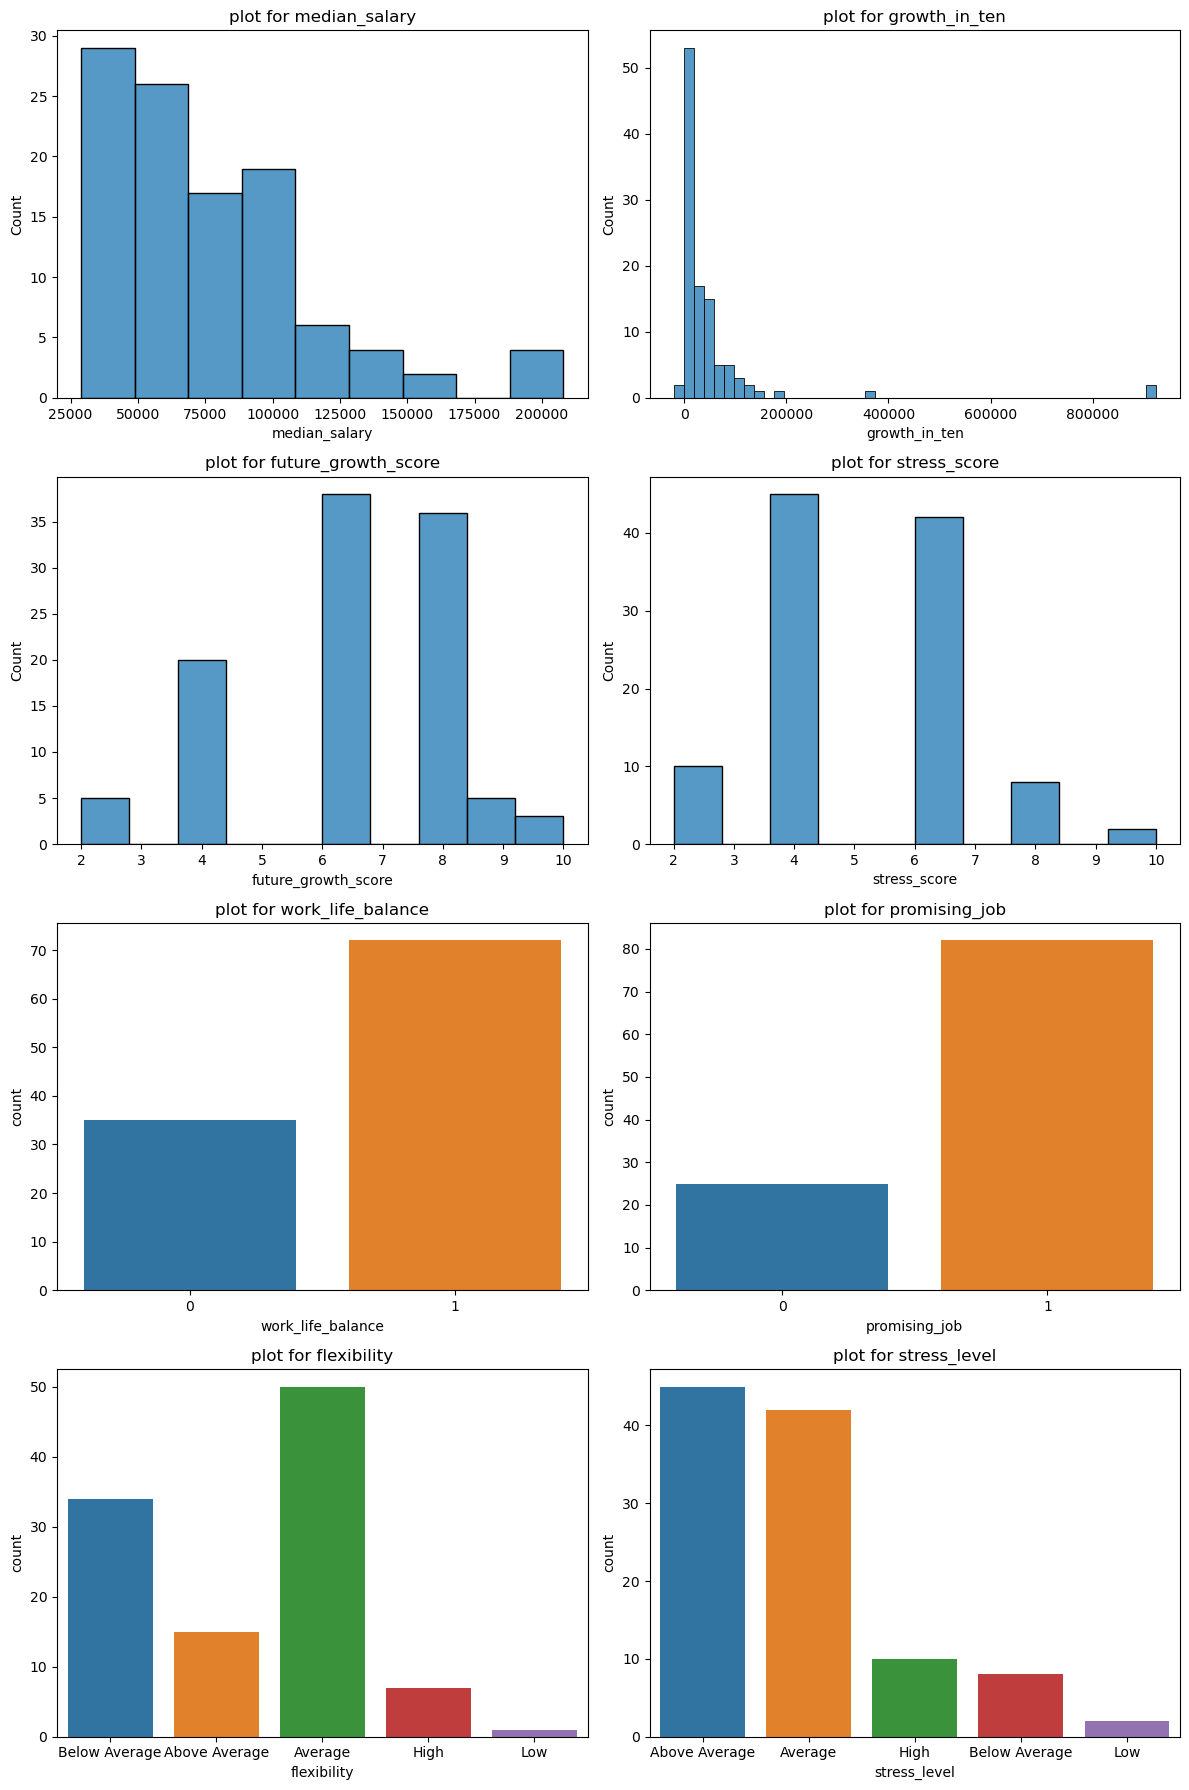

In [35]:
fig, axes = plt.subplots(4, 2, figsize=(12, 18))
axes = axes.flatten()

## put different kind of columns into different lists
num_cols = ['median_salary', 'growth_in_ten', 'future_growth_score', 'stress_score']
cate_cols = ['work_life_balance', 'promising_job', 'flexibility', 'stress_level']

## use histpolt to show numerical variables
for i, col in enumerate(num_cols):
    sns.histplot(x=jobs_df[col], ax=axes[i])
    axes[i].set_title(f'plot for {col}')

## use countplots to show categorical variables
for i, col in enumerate(cate_cols, start=len(num_cols)):
    sns.countplot(x=col, data=jobs_df, ax=axes[i])
    axes[i].set_title(f'plot for {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('count')

plt.tight_layout()
plt.show()

as we see in the plot of growth_in_ten, there are some outcomes that are too far away from others, so we kick them out for the benifits of our later analysis. 

In [36]:
jobs_df=jobs_df[jobs_df["growth_in_ten"]<200000]

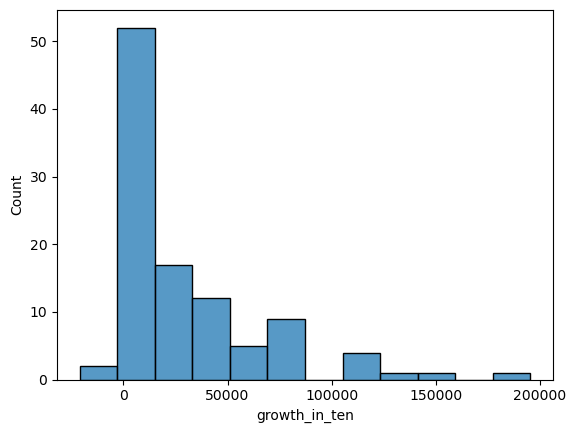

In [37]:
sns.histplot(data=jobs_df["growth_in_ten"]);

now it's much better

### Making two bivariate plots containing the outcome variable and two predictors (one predictor per plot)  

outcome variable: median_salary  
predictor: growth_in_ten, stress_score

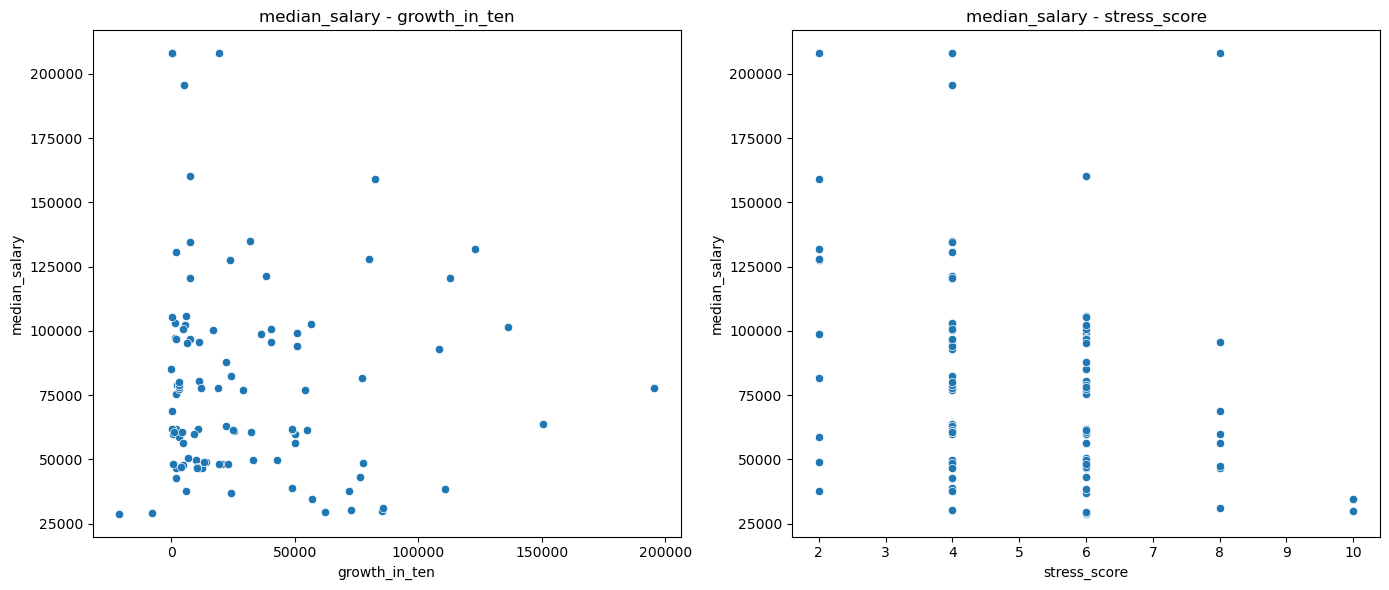

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x="growth_in_ten", y="median_salary", data=jobs_df, ax=axes[0])
axes[0].set_title('median_salary - growth_in_ten')

sns.scatterplot(x="stress_score", y="median_salary", data=jobs_df, ax=axes[1])
axes[1].set_title('median_salary - stress_score')

plt.tight_layout()
plt.show()

#### linear regression models:  
• A regression model for one of your continuous/interval outcome variables and a predictor of interest  
(e.g. predicting the number of language translations for a Wikipedia page as a function of the length of the page) 

outcome variable: median_salary   
since salary consists of very large numbers and is of different magnitudes, i chose to take log here   
predictor: stress_score


• Interpret each of the coefficients in all models you run  
• For the interpretation of the logistic regression coefficient, you only need to interpret the sign (i.e. -/+) of the coefficient and whether it is statistically significant.
• Explain whether you should include a squared or log term for any of your predictors or whether you should take the log of your outcome

In [39]:
est_mod = ols('np.log(median_salary)~stress_score', data=jobs_df).fit()
est_mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.5900,0.136,84.977,0.000,11.319,11.861
stress_score,-0.0861,0.026,-3.343,0.001,-0.137,-0.035


interpretation:  
the coefficient of stress_score(𝛽1)means the effect of stress_score on log(median_salary).  
the coef for stess_score is nagitave, which means higher stress_score is linked to relatively lower log(median_salary). one unit of increase in stress_score will cause log(median_salary) to decrease 0.0861 according to this model

p<0.05, so we can say the effect of stress_score to future growth is statistically significant. 

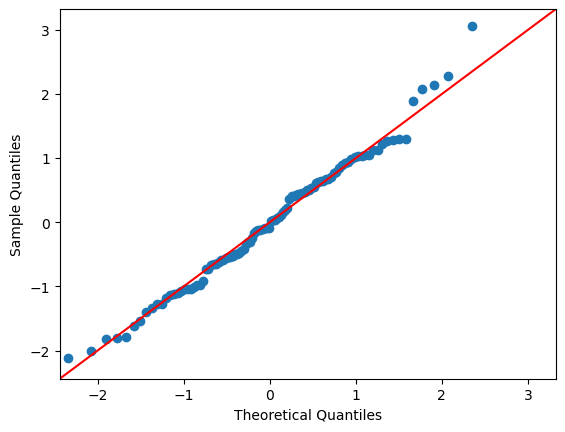

In [40]:
# Generate Q-Q plot
sm.qqplot(est_mod.resid, line ='45', fit=True);

data points are generally normally distributed, validating the assumption of normality for the analyzed variable.

#### Conduct a logistic regression:  
• A regression model for one of your binary outcome variables and a predictor of interest (e.g. predicting whether the number of language translations for a Wikipedia page is less than 5 as function of the length of the page)  

binary outcome variables:work_life_balance  
predictor:future_growth_score

In [41]:
logm = smf.logit('work_life_balance~future_growth_score',data=jobs_df).fit()
logm.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.624537
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.9432,0.759,1.242,0.214,-0.545,2.431
future_growth_score,-0.0282,0.116,-0.243,0.808,-0.255,0.199


coefficient of future_growth_score is negative, means an increase in future_growth_score is associated with a decreased possibility for work_life_balance to be 1.  
p>0.05, means their relationship is not statistically significant

#### Conduct a linear or logistic model as above, but include a control and explain what happens to the coefficient on your predictor of interest when the control is included (e.g. predicting the number of language translations for a Wikipedia page as a function of the length of the entry, controlling for whether the topic is about politics)  

in clude a control: future_growth_score

In [42]:
est_mod = ols('np.log(median_salary)~stress_score+future_growth_score', data=jobs_df).fit()
est_mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.4708,0.220,52.067,0.000,11.034,11.908
stress_score,-0.0832,0.026,-3.177,0.002,-0.135,-0.031
future_growth_score,0.0166,0.024,0.690,0.492,-0.031,0.064


after adding the control variable, the coef of stress_score changed to -0.0832, means the nagative relationship between stress_score and log(median_salary) became weaker. the p value for it also changed from 0.001 to 0.002, means the relationship between stress_score and log(median_salary) became less statistically significant.  

the coefficient for stress_score represents how the change of log(median_salary) is associated with one-unit's change in stress_score when the value of future_growth_score is constant. here we can say when future_growth_score is the same, one-unit increase in stress_score will cause log(median_salary) to decrease 0.0832.  
The coefficient for future_growth_score means how the change in log(median_salary) is associated change in future_growth_score when stress_score is constant. when stress_score is the same, one-unit increase in future_growth_score will cause log(median_salary) to increase by 0.0166.  

the p values of stress_score is <0.05,means the relationship between stress_score and log(salary)is statistically significant.  
but p of future_growth_score is >0.05, means this relationship between future_growth_score and log(salary is not statistically significant.

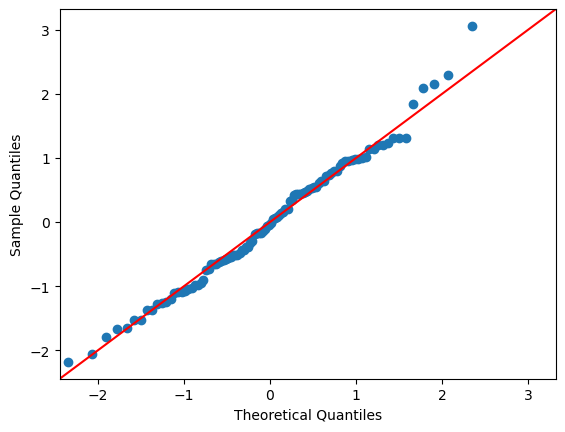

In [43]:
sm.qqplot(est_mod.resid, line ='45', fit=True);

data points are generally normally distributed, validating the assumption of normality for the analyzed variable.

#### Conduct a linear or logistic regression model as above, but include an interaction between your predictor of interest and another variable (e.g. predicting the number of language translations for a Wikipedia page as a function of the length of the page, whether the topic is about politics, and the interaction between these variables)  

In [44]:
# predict the stress_score as a function of log(median_salary), whether it's a promising_job and the interaction between the two variables
est_mod = ols('np.log(median_salary)~stress_score+promising_job+stress_score*promising_job', data=jobs_df).fit()
est_mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.2536,0.321,35.026,0.000,10.616,11.891
stress_score,-0.0310,0.059,-0.522,0.603,-0.149,0.087
promising_job,0.4101,0.355,1.155,0.251,-0.294,1.115
stress_score:promising_job,-0.0668,0.066,-1.012,0.314,-0.198,0.064


the coefficient for stress_score represents how the change of log(median_salary) is associated with one-unit's change in stress_score when "promising_job" is constant. similarly, the coefficient for promising_job means how the change in log(median_salary) is associated change in promising_job when stress_score is constant.  

interaction coefficient indicates how the relationship between stress_score and log(median_salary) changes with the change in promising_job. here it is negative, suggesting that the effect of stress_score on log(median_salary) decreases if it is a promising_job

the p values of stress_score is >0.05,means the relationship between stress_score and log(salary)is not statistically significant.  
p for promising_job is >0.05, means this relationship between promising_job and log(salary) is not statistically significant.  
p for interaction term is >0.05, suggesting the interaction effect in this model isn't statistically significant. 

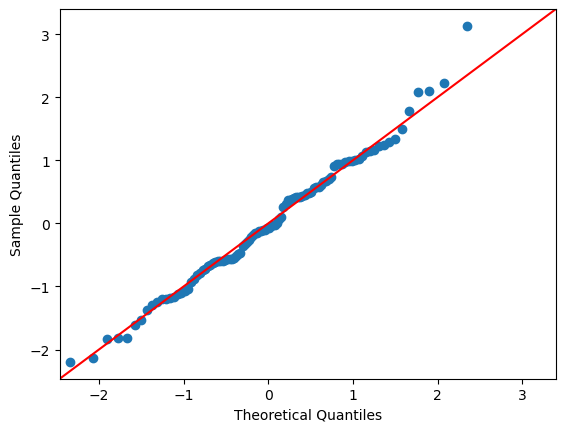

In [45]:
sm.qqplot(est_mod.resid, line ='45', fit=True);

data points are generally normally distributed, validating the assumption of normality for the analyzed variable.

#### Conduct a linear or logistic regression model for any outcome of interest with a non-binary categorical variable (a variable with more than 2 categories) as the predictor   

outcome: median_salary  
predictor: flexibility	

In [46]:
est_mod = ols('np.log(median_salary)~flexibility', data=jobs_df).fit()
est_mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.3234,0.120,94.031,0.000,11.084,11.562
flexibility[T.Average],-0.2637,0.136,-1.935,0.056,-0.534,0.007
flexibility[T.Below Average],-0.0194,0.144,-0.134,0.894,-0.306,0.267
flexibility[T.High],-0.4478,0.209,-2.147,0.034,-0.862,-0.034
flexibility[T.Low],-0.2950,0.466,-0.633,0.528,-1.220,0.630


having an "Average" flexibility level is associated with a decrease of 0.2637 in log(median_salary), compared to when flexibility is Above Average. p value (0.056) is >0.05, indicating that this effect is not statistically significant.  
having an "Below Average" flexibility level is associated with a decrease of 0.0194 in log(median_salary), compared to when flexibility is Above Average. p value (0.894) is >0.05, indicating that this effect is not statistically significant  
having an "High" flexibility level is associated with a decrease of 0.4478 in log(median_salary), compared to when flexibility is Above Average. p value (0.034) is <0.05, indicating that this effect is statistically significant  
having an "Low" flexibility level is associated with a decrease of 0.2950 in log(median_salary), compared to when flexibility is Above Average. p value (0.528) is >0.05, indicating that this effect is not statistically significant